**LOPO using level-1 training data**

---
For each training fold trained individual modality models (FER, pupil and GSR) directly on the training data and generated predictions on a small validation split in the training set.


Mounting drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.stats import pearsonr
import statsmodels.api as sm
from lightgbm import LGBMRegressor
from typing import List
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
full_video_directory = r"/content/drive/MyDrive/Data-Multimotion/Features-NEW/Full"
intervals_directory = r"/content/drive/MyDrive/Data-Multimotion/Features-NEW/Intervals"
ground_truth_directory = r"/content/drive/MyDrive/Data-Multimotion/Ground truth"
results_directory = r"/content/drive/MyDrive/Data-Multimotion/Results"

# Data

In [ ]:
videos = [
     "HN_1","HN_2_H","HN_4","HN_5","HN_6","LP_3","LP_4",
     "LP_6","LN_1","LN_2","LN_3","LN_4","LN_5","LN_6",
     "LN_7_N","LN_9","HP_1_L","HP_2","HP_3_L","HP_4",
     "HP_6","HP_7_H","HN_3_H","HN_9","HN_7","LP_1",
     "LP_2","LP_5","LP_7","LP_9","HP_5","HP_9",
     "HN_2_L","HN_3_L","HP_1_H","HP_3_H","HP_7_L","LN_7_P"]

**Loading FER data:**

In [ ]:
# Full FER - loading the csv
df_fer_full = pd.read_csv(os.path.join(full_video_directory, "fer_features.csv"))

In [ ]:
# Intervals FER - loading the csv
df_fer_intervals = pd.read_csv(os.path.join(intervals_directory, "fer_features_intervals.csv"))

In [ ]:
df_fer = pd.merge(df_fer_full, df_fer_intervals, on=['participant', 'video'],
                               suffixes=('_whole', '_interval'))

In [ ]:
len(df_fer['participant'].unique())

50

I have to remove participants who don't have FER at all (this is because if they did not have FER in the raw files, I would just put NANs for all videos when doing feature extraction)

In [ ]:
# Columns to exclude from NaN check
exclude_cols = ['participant', 'video']

# Feature columns to check for NaNs
feature_cols = [col for col in df_fer.columns if col not in exclude_cols]

# Group by participant and check if all their feature values are NaN
participants_to_remove = df_fer.groupby('participant')[feature_cols].apply(
    lambda x: x.isna().all(axis=1).all()
)

# Filter participant IDs to remove
participants_to_remove = participants_to_remove[participants_to_remove].index.tolist()

# Remove those participants from the DataFrame
df_fer_cleaned = df_fer[~df_fer['participant'].isin(participants_to_remove)]

# Show results
print(f"Number of participants removed: {len(participants_to_remove)}")
print("Participants removed:")
print(participants_to_remove)

df_fer = df_fer_cleaned

Number of participants removed: 0
Participants removed:
[]


**Loading Pupil data:**

In [ ]:
# Full Pupil - loading the csv
df_pupil_full = pd.read_csv(os.path.join(full_video_directory, "Not_Interval_60_part_all_stat_features_12062025.csv"))
df_pupil_full.rename(columns={"Participant": "participant", "simuli_name_1": "video"}, inplace=True)
df_pupil_full.drop(columns=['Arousal', 'Valence', 'simuli_name_2','Unnamed: 0'], inplace=True)

In [ ]:
# Intervals - Loading the csv
df_pupil_interval = pd.read_csv(os.path.join(intervals_directory, "Interval_60_part_all_stat_features_01062025.csv"))
df_pupil_interval.rename(columns={"Participant": "participant", "simuli_name_1": "video"}, inplace=True)
df_pupil_interval.drop(columns=['Arousal', 'Valence', 'simuli_name_2', 'Unnamed: 0'], inplace=True)

In [ ]:
# Merging the intervals and full GSR features
df_pupil = pd.merge(df_pupil_full, df_pupil_interval, on=['participant', 'video'],
                               suffixes=('_whole', '_interval'))

**Loading GSR data:**

In [ ]:
# Full - Loading the csv
df_gsr_full = pd.read_csv(os.path.join(full_video_directory, "gsr_features.csv"))
df_gsr_full.rename(columns={"ParticipantID": "participant", "StimulusName": "video"}, inplace=True)


In [ ]:
# Intervals - Loading the csv
df_gsr_intervals = pd.read_csv(os.path.join(intervals_directory, "gsr_features_intervals.csv"))
df_gsr_intervals.rename(columns={"ParticipantID": "participant", "StimulusName_0": "video"}, inplace=True)


In [ ]:
# Merging the intervals and full GSR features
df_gsr = pd.merge(df_gsr_full, df_gsr_intervals, on=['participant', 'video'],
                               suffixes=('_whole', '_interval'))


In [ ]:
# Count total rows per participant
rows_per_participant = df_gsr['participant'].value_counts().sort_index()

# Count unique videos per participant
videos_per_participant = df_gsr.groupby('participant')['video'].nunique().sort_index()

# Combine into a single DataFrame to show
summary = pd.DataFrame({
    'rows': rows_per_participant,
    'unique_videos': videos_per_participant
})

print(summary)

             rows  unique_videos
participant                     
22DFx          36             34
4FoNM          36             34
5BJD3          36             34
5KB3V          36             34
6GSd4          36             34
7yqP3          36             34
8vDRG          36             34
9FGka          36             34
A5feTy         36             34
Bs73           36             34
CVgs2          36             34
CoQmx          36             34
Cr1sTi         36             34
D9Hh9          36             34
Dwf5T          36             34
EJOiBs         36             34
ERqc8          36             34
EXAMPLE        36             34
F5tXL          36             34
F8mDn          36             34
Fjil72         36             34
Fk2oP          36             34
Fyt7d          36             34
G4Egk          36             34
G4dLl          36             34
G5XzoP         36             34
GFGzP          36             34
GHft8          36             34
Gax8      

In [ ]:
len(df_gsr['participant'].unique())

59

In [ ]:
# Merge df_fer and df_pupil first
df_merged = pd.merge(df_fer, df_pupil, on=['participant', 'video'], how='inner')

# Then merge with df_gsr
df = pd.merge(df_merged, df_gsr, on=['participant', 'video'], how='inner')

In [ ]:
len(df['participant'].unique())

45

Some participants that were not removed do not have all 38 videos so I am filtering to keep only those that have same umber of videos for all features.

In [ ]:
participant_col = 'participant'
video_col = 'video'

fer_features = [col for col in df_fer.columns if col not in [participant_col, video_col]]
pupil_features = [col for col in df_pupil.columns if col not in [participant_col, video_col]]
gsr_features = [col for col in df_gsr.columns if col not in [participant_col, video_col]]

In [ ]:
df.head()

,participant,video,FER_Mean_Valence_whole,FER_Mean_Arousal_whole,FER_Std_Valence_whole,FER_Std_Arousal_whole,FER_Kurtosis_Valence_whole,FER_Kurtosis_Arousal_whole,FER_Max_Valence_whole,FER_Max_Arousal_whole,...,skewMFCC_3_interval,skewMFCC_4_interval,skewMFCC_5_interval,skewMFCC_6_interval,skewMFCC_7_interval,skewMFCC_8_interval,skewMFCC_9_interval,skewMFCC_10_interval,skewMFCC_11_interval,skewMFCC_12_interval
0,F5tXL,HN_1,0.065198,-0.071080,0.105994,0.214129,1.295447,6.192118,0.476865,0.824261,...,2.057717,1.912975,1.777293,1.653048,1.551893,1.459362,1.381791,1.307889,1.244335,1.185401
1,F5tXL,HN_2_H,0.034264,0.001731,0.052637,0.039278,6.087377,101.207316,0.270283,0.469452,...,0.485612,0.569221,0.615418,0.643293,0.660687,0.672816,0.681663,0.688913,0.694940,0.700284
2,F5tXL,HN_2_L,0.136173,0.067942,0.100219,0.189019,-0.883914,6.199358,0.394866,0.723476,...,1.493007,1.714367,1.858296,1.957641,2.027385,2.078396,2.115878,2.144380,2.165929,2.182612
3,F5tXL,HN_3_H,0.012117,0.036080,0.051279,0.167949,18.683935,17.486036,0.313078,0.835188,...,2.503512,2.656415,2.745447,2.798472,2.831892,2.852060,2.865410,2.872750,2.877586,2.879863
4,F5tXL,HN_3_L,0.002395,-0.001458,0.002747,0.003737,21.097049,73.507299,0.021314,0.039313,...,1.418646,1.554342,1.627412,1.667935,1.689048,1.699616,1.703471,1.703776,1.701651,1.698295


In [ ]:
# Count unique participants
num_participants = df['participant'].nunique()
print(f"Number of unique participants: {num_participants}")

# Count number of videos per participant
videos_per_participant = df.groupby('participant')['video'].nunique()

# Display summary statistics
print("\nVideos per participant (summary):")
print(videos_per_participant.describe())

# See full list of how many videos each participant has
print(videos_per_participant.sort_values())

Number of unique participants: 45

Videos per participant (summary):
count    45.000000
mean     33.800000
std       0.694131
min      30.000000
25%      34.000000
50%      34.000000
75%      34.000000
max      34.000000
Name: video, dtype: float64
participant
GFGzP      30
Bs73       32
G4dLl      33
Xd3foP9    33
kH4Dd      33
CVgs2      34
A5feTy     34
4FoNM      34
D9Hh9      34
Dwf5T      34
ERqc8      34
EXAMPLE    34
F5tXL      34
F8mDn      34
6GSd4      34
5KB3V      34
G4Egk      34
Fjil72     34
G5XzoP     34
Gax8       34
Gftw5      34
Hx7dO      34
KWgkc      34
Kgh4P3     34
KoG5ii     34
LR96S      34
M4t7k      34
NMy2s      34
O1pGR      34
PPjCX      34
CoQmx      34
Cr1sTi     34
SI3pa2     34
Pi9803     34
WQzBV      34
V9D5x      34
XhsN0o     34
gf5X       34
gjGzb      34
hMHEK1     34
sop2d      34
tMGNS      34
urJvc      34
wohkw      34
yb3T2      34
Name: video, dtype: int64


### Loading ground truth

In [ ]:
# Load full ground truth (this is done only once)
gt_full_set = pd.read_csv(os.path.join(ground_truth_directory, "individual_ground_truth.csv"))

# Renaming so it is the same as FER and Pupil
gt_full_set.rename(columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True)

In [ ]:
def load_ground_truth_exclude(participant_id):
    """ Function to load ground truth file for excluding one participant for Leave One Participant Out. """

    # Load the ground truth file excluding this participant
    file_path = os.path.join(ground_truth_directory + f"/Leave-one-out/individual_ground_truth_no_{participant_id}.csv")

    gt_df = pd.read_csv(file_path)
    return gt_df

### Cleaning

In [ ]:
# Get columns with NaNs and sort by number of NaNs
nan_summary = df.isnull().sum()
nan_summary = nan_summary[nan_summary > 0].sort_values(ascending=False)

# Display the columns with the most NaNs
print(nan_summary.head(100))

corr_kurtosis_whole       1301
corr_skewness_whole       1301
corr_auc_whole            1301
diff_kurtosis_whole       1301
diff_skewness_whole       1301
diff_auc_whole            1301
corr_kurtosis_interval     537
corr_skewness_interval     537
corr_auc_interval          537
diff_kurtosis_interval     537
diff_skewness_interval     537
diff_auc_interval          537
dtype: int64


In [ ]:
# Get column names with NaNs
missing_cols = nan_summary.index.tolist()

In [ ]:
df[missing_cols] = df[missing_cols].fillna(0)

# Modality model - stacked SVR LGBM model

Defining the class for the model to be used for modality (FER and GSR).

In [ ]:
# Class for the Stacked SVR LGBM model
class StackedSvrLgbmModel:
    _lgbm_model: LGBMRegressor
    _svr_model: SVR
    _final_regressor: LinearRegression
    svr_features: List[str]
    lgbm_features: List[str]

    def __init__(self,
                 svr_features: List[str],
                 lgbm_features: List[str],
                 # SVR parameters
                 kernel: str,
                 degree: int,
                 gamma: float,
                 coef0: float,
                 C: float,
                 tol: float,
                 epsilon: float,
                 # LGBM parameters
                 num_leaves: int,
                 max_depth: int,
                 learning_rate: float,
                 n_estimators: int,
                 min_child_samples: int,
                 subsample: float,
                 colsample_bytree: float):
        self._lgbm_model = LGBMRegressor(n_estimators=n_estimators, num_leaves=num_leaves, max_depth=max_depth,
                                         learning_rate=learning_rate, colsample_bytree=colsample_bytree,
                                         min_child_samples=min_child_samples, subsample=subsample,
                                         n_jobs=-1, boosting_type='dart', force_col_wise=True, verbosity=-1)
        self._svr_model = SVR(kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, tol=tol, C=C, epsilon=epsilon)
        self._final_regressor = LinearRegression()

        self.svr_features = svr_features
        self.lgbm_features = lgbm_features

    def train_and_val(self, train_df: pd.DataFrame, val_df: pd.DataFrame | None,
                      Y_train: pd.DataFrame) -> pd.DataFrame | None:

        X_train_svr = train_df[self.svr_features].to_numpy()
        X_train_lgbm = train_df[self.lgbm_features].astype(float)

        X_train_lgbm, X_val_lgbm, Y_final_regressor_train, Y_final_regressor_val = train_test_split(
            X_train_lgbm,
            Y_train,
            test_size=0.1,
            random_state=42)
        X_train_svr, X_val_svr, _, _ = train_test_split(X_train_svr,
                                                        Y_train,
                                                        test_size=0.1,
                                                        random_state=42)

        self._lgbm_model.fit(X_train_lgbm, Y_final_regressor_train)
        self._svr_model.fit(X_train_svr, Y_final_regressor_train)

        Y_pred_lgbm_train = self._lgbm_model.predict(X_val_lgbm)
        Y_pred_svr_train = self._svr_model.predict(X_val_svr)
        X_final_regressor_train = np.column_stack([Y_pred_lgbm_train, Y_pred_svr_train])
        self._final_regressor.fit(X_final_regressor_train, Y_final_regressor_val)

        if val_df is not None:
            X_test_svr = val_df[self.svr_features].to_numpy()
            X_test_lgbm = val_df[self.lgbm_features].astype(float)

            Y_pred_lgbm_test = self._lgbm_model.predict(X_test_lgbm)
            Y_pred_svr_test = self._svr_model.predict(X_test_svr)
            X_final_regressor_test = np.column_stack([Y_pred_lgbm_test, Y_pred_svr_test])
            Y_pred = self._final_regressor.predict(X_final_regressor_test)
            return Y_pred

        return None

    def test(self, test_df: pd.DataFrame):
        X_test_svr = test_df[self.svr_features].to_numpy()
        X_test_lgbm = test_df[self.lgbm_features].astype(float)

        Y_pred_lgbm_test = self._lgbm_model.predict(X_test_lgbm)
        Y_pred_svr_test = self._svr_model.predict(X_test_svr)

        X_final_regressor_test = np.column_stack([Y_pred_lgbm_test, Y_pred_svr_test])
        Y_pred = self._final_regressor.predict(X_final_regressor_test)

        return Y_pred


# Arousal

Defining the parameters along with the features to be used for each modality:

In [ ]:
ar_modality_configs = {
    "FER": {
        "params": {
            # SVR
            "kernel": "rbf",
            "degree": 2,
            "gamma": 0.005,
            "coef0": 1,
            "tol": 0.1,
            "C": 0.5,
            "epsilon": 0.1,

            # LGBM
            "num_leaves": 31,
            "max_depth": -1,
            "learning_rate": 0.01,
            "n_estimators": 500,
            "min_child_samples": 20,
            "subsample": 0.6,
            "colsample_bytree": 0.6,
        },
        "svr_features": [
            'FER_Max_Arousal_whole', 'FER_Mean_Arousal_whole', 'FER_Min_Valence_interval',
            'FER_Mean_Arousal_interval', 'FER_Std_Arousal_whole', 'FER_Mean_Valence_interval'
        ],
        "lgbm_features": [
            'FER_Kurtosis_Valence_whole', 'FER_Kurtosis_Valence_interval', 'FER_Kurtosis_Arousal_interval',
            'FER_Kurtosis_Arousal_whole', 'FER_Max_Arousal_whole', 'FER_Min_Arousal_interval',
            'FER_Max_Valence_whole', 'FER_Min_Valence_whole', 'FER_Max_Arousal_interval',
            'FER_Mean_Valence_interval', 'FER_Std_Valence_interval', 'FER_Min_Valence_interval',
            'FER_Mean_Valence_whole', 'FER_Mean_Arousal_interval', 'FER_Mean_Arousal_whole',
            'FER_Min_Arousal_whole', 'FER_Std_Arousal_whole', 'FER_Std_Arousal_interval',
            'FER_Std_Valence_whole', 'FER_Max_Valence_interval'
        ]
    },
    "Pupil": {
        "params": {
            # SVR
            "kernel": "rbf",
            "degree": 2,
            "gamma": 1e-3,
            "coef0": 1,
            "tol": 5e-3,
            "C": 5,
            "epsilon": 0.1,

            # LGBM
            "num_leaves": 31,
            "max_depth": -1,
            "learning_rate": 0.1,
            "n_estimators": 100,
            "min_child_samples": 20,
            "subsample": 1.0,
            "colsample_bytree": 1.0,
        },
        "svr_features": [
            'corr_auc_whole', 'diff_auc_whole', 'corr_mean_whole', 'avg_max_whole', 'avg_min_whole', 'corr_max_whole', 'corr_min_whole',
            'diff_mean_whole', 'avg_mean_whole', 'avg_skewness_whole', 'avg_std_whole', 'diff_std_whole', 'corr_std_whole',
            'diff_min_whole', 'corr_skewness_whole', 'diff_max_whole',

             'corr_auc_interval', 'diff_auc_interval', 'corr_mean_interval', 'avg_max_interval', 'avg_min_interval', 'corr_max_interval', 'corr_min_interval',
            'diff_mean_interval', 'avg_mean_interval', 'avg_skewness_interval', 'avg_std_interval', 'diff_std_interval', 'corr_std_interval',
            'diff_min_interval', 'corr_skewness_interval', 'diff_max_interval'
        ],
        "lgbm_features": [
          'avg_max_whole', 'avg_min_whole', 'avg_mean_whole',
          'avg_std_whole', 'avg_kurtosis_whole', 'avg_skewness_whole', 'avg_auc_whole', 'corr_max_whole',
          'corr_min_whole', 'corr_mean_whole', 'corr_std_whole', 'corr_kurtosis_whole', 'corr_skewness_whole',
          'corr_auc_whole', 'diff_max_whole', 'diff_min_whole', 'diff_mean_whole', 'diff_std_whole',
          'diff_kurtosis_whole', 'diff_skewness_whole', 'diff_auc_whole',


          'avg_max_interval', 'avg_min_interval', 'avg_mean_interval',
          'avg_std_interval', 'avg_kurtosis_interval', 'avg_skewness_interval', 'avg_auc_interval', 'corr_max_interval',
          'corr_min_interval', 'corr_mean_interval', 'corr_std_interval', 'corr_kurtosis_interval', 'corr_skewness_interval',
          'corr_auc_interval', 'diff_max_interval', 'diff_min_interval', 'diff_mean_interval', 'diff_std_interval',
          'diff_kurtosis_interval', 'diff_skewness_interval', 'diff_auc_interval'
        ],
    },
    "GSR": {
        "params": {
            # SVR
            "kernel": "rbf",
            "degree": 2,
            "gamma": 1e-4,
            "coef0": 1,
            "tol": 5e-3,
            "C": 0.5,
            "epsilon": 0.05,

            # LGBM
            "num_leaves": 31,
            "max_depth": -1,
            "learning_rate": 0.1,
            "n_estimators": 300,
            "min_child_samples": 20,
            "subsample": 0.6,
            "colsample_bytree": 0.6,
        },

        "svr_features": [
            'freqKurtEDA_whole', 'freqKurtEDA_interval', 'entropyWavelet_4_interval', 'medianMFCC_1_whole',
            'meanMFCC_1_interval', 'complexity_interval', 'energyDistribution_4_interval',
            'meanDerivative_whole', 'energyDistribution_0_whole', 'energyDistribution_1_whole',
            'energyDistribution_2_whole', 'energyDistribution_3_whole', 'meanNegativeSecondDerivative_whole',
            'phasicPowers_1_whole'
        ],
        "lgbm_features": [
            "freqKurtEDA_whole", "freqKurtEDA_interval", "freqSkewEDA_whole", "freqSkewEDA_interval",
            "energyDistribution_0_whole", "stdMFCC_12_interval", "stdMFCC_11_whole", "stdMFCC_11_interval",
            "stdMFCC_10_interval", "stdMFCC_12_whole", "spectralPowerBand(0.3-0.4)_interval",
            "energyDistribution_1_whole", "energyDistribution_0_interval",
            "spectralPowerBand(0.4-0.5)_interval", "energyWavelet_3_interval", "energyWavelet_2_interval",
            "sumAreas_interval", "meanNegativeSecondDerivative_whole", "energyDistribution_2_whole",
            "energyDistribution_2_interval", "phasicPowers_1_whole", "kurtMFCC_12_interval",
            "entropyWavelet_0_whole", "stdMFCC_10_whole", "energyDistribution_8_interval",
            "energyWavelet_0_interval", "hoc_5_whole", "skewMFCC_12_interval", "skewMFCC_10_interval",
            "energyDistribution_6_whole", "energyDistribution_8_whole", "medianMFCC_10_interval",
            "activity_interval", "meanMFCC_6_interval", "rmsWavelet_3_interval", "energyWavelet_2_whole",
            "hoc_1_whole", "stdMFCC_1_whole", "spectralPowerBand(0.2-0.3)_interval",
            "meanMFCC_11_interval", "medianMFCC_12_interval", "energyDistribution_4_interval",
            "stdMFCC_9_whole", "skewMFCC_1_interval", "skewMFCC_8_interval", "medianMFCC_2_interval",
            "meanSecondDerivative_interval", "meanMFCC_12_interval", "energyDistribution_4_whole",
            "meanMFCC_7_interval"
        ]
    }
}


In [ ]:
def get_train_test_data(df, gt_full_set, test_pid):
    """Split data into train and test and merge with the correct ground truth."""
    test_data = df[df["participant"] == test_pid].copy()
    test_gt = gt_full_set[gt_full_set["participant"] == test_pid]
    test_data = test_data.merge(
    test_gt[["participant", "video", "Arousal"]],
      on=["participant", "video"],
          how="inner",
      )

    train_data = df[df["participant"] != test_pid].copy()

    pid_gt = load_ground_truth_exclude(test_pid)
    pid_gt.rename(
          columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True
      )

    train_data = train_data.merge(
          pid_gt[["participant", "video", "Arousal"]],
          on=["participant", "video"],
          how="inner",
      )

    return train_data, test_data


def train_modality_model(
    train_data, test_data, type_features, features, svr_features, lgbm_features, stacked_params
):
    """Train model on specific modality features."""
    X_train = train_data[features]
    y_train = train_data["Arousal"]
    X_test = test_data[features]
    y_test = test_data["Arousal"]

    train_df = pd.DataFrame(X_train, columns=features)
    train_df["Arousal"] = y_train.values
    test_df = pd.DataFrame(X_test, columns=features)


    if type_features == "pupil":
      model = HistGradientBoostingRegressor(max_depth=5, learning_rate=0.1, max_iter=100)
      model.fit(X_train, y_train)
      preds_val = model.predict(X_test)
      preds_train = model.predict(X_train)
    else:
      model = StackedSvrLgbmModel(
          svr_features=svr_features, lgbm_features=lgbm_features, **stacked_params
      )

      preds_val = model.train_and_val(train_df, test_df, y_train)
      preds_train = model.test(train_df)

    return model, preds_train, preds_val, y_test.values


def evaluate_fusion_model(y_true, y_pred):
    """ Calculate evaluation metrics. """
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (y_true.max() - y_true.min())
    r2 = r2_score(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)
    return {"NRMSE": nrmse, "R2": r2, "corr": corr, "p": p_val}


def get_level1_train_data(
    train_data, fer_features, pupil_features, gsr_features, val_ratio=0.1
):
    """ Create validation set predictions for training the fusion model (level-1). """
    modality_train, modality_val = train_test_split(
        train_data, test_size=val_ratio, random_state=42
    )

    # Train each modality model on modality_train
    # FER MODEL
    model_fer, _, val_fer, _ = train_modality_model(
        modality_train,
        modality_val,
        "fer",
        fer_features,
        svr_features=ar_modality_configs["FER"]["svr_features"],
        lgbm_features=ar_modality_configs["FER"]["lgbm_features"],
        stacked_params=ar_modality_configs["FER"]["params"],
    )

    # PUPIL MODEL
    model_pupil, _, val_pupil, _ = train_modality_model(
        modality_train,
        modality_val,
        "pupil",
        pupil_features,
        svr_features=ar_modality_configs["Pupil"]["svr_features"],
        lgbm_features=ar_modality_configs["Pupil"]["lgbm_features"],
        stacked_params=ar_modality_configs["Pupil"]["params"],
    )

    # GSR MODEL
    model_gsr, _, val_gsr, y_val = train_modality_model(
        modality_train,
        modality_val,
        "gsr",
        gsr_features,
        svr_features=ar_modality_configs["GSR"]["svr_features"],
        lgbm_features=ar_modality_configs["GSR"]["lgbm_features"],
        stacked_params=ar_modality_configs["GSR"]["params"],
    )

    # Stack predictions to create fusion training input
    fusion_X_train = np.vstack([val_fer, val_pupil, val_gsr]).T
    fusion_y_train = y_val

    return fusion_X_train, fusion_y_train, model_fer, model_pupil, model_gsr


def run_participant_loop(df, gt_full_set, fusion_model_cls, fusion_model_kwargs={}):
    """ Get each participant, train model, make predictions, evaluate. """
    participants = df["participant"].unique()
    participant_results = []
    fusion_weights = {}
    all_fusion_preds, all_true_values, all_test_participants = [], [], []

    for test_pid in participants:
        train_data, test_data = get_train_test_data(df, gt_full_set, test_pid)  # Merge the train (all without pid) and test (pid) with the GT
        if train_data is None or test_data is None:
            continue  # Skip invalid participant

        # Get level-1 training data without leakage
        (
            fusion_X_train,
            fusion_y_train,
            model_fer,
            model_pupil,
            model_gsr,
        ) = get_level1_train_data(
            train_data, fer_features, pupil_features, gsr_features
        )

        # Predict on test set using the trained modality models
        X_test_fer = test_data[fer_features]
        X_test_pupil = test_data[pupil_features]
        X_test_gsr = test_data[gsr_features]
        y_test = test_data["Arousal"].values

        # Predict using trained models
        test_fer_preds = model_fer.test(pd.DataFrame(X_test_fer, columns=fer_features))
        test_pupil_preds = model_pupil.predict(pd.DataFrame(X_test_pupil, columns=pupil_features))
        test_gsr_preds = model_gsr.test(pd.DataFrame(X_test_gsr, columns=gsr_features))

        # Evaluate modalities individually
        fer_metrics = evaluate_fusion_model(y_test, test_fer_preds)
        pupil_metrics = evaluate_fusion_model(y_test, test_pupil_preds)
        gsr_metrics = evaluate_fusion_model(y_test, test_gsr_preds)

        # Rename keys to make clear it's per modality
        fer_metrics = {f"FER_{k}": v for k, v in fer_metrics.items()}
        pupil_metrics = {f"Pupil_{k}": v for k, v in pupil_metrics.items()}
        gsr_metrics = {f"GSR_{k}": v for k, v in gsr_metrics.items()}

        # Stack for fusion
        fusion_X_test = np.vstack([test_fer_preds, test_pupil_preds, test_gsr_preds]).T

        # Normalize fusion model input
        fusion_scaler = StandardScaler()
        fusion_X_train = fusion_scaler.fit_transform(fusion_X_train)
        fusion_X_test = fusion_scaler.transform(fusion_X_test)

        # Train and predict with fusion model
        model_fusion = fusion_model_cls(**fusion_model_kwargs)
        model_fusion.fit(fusion_X_train, fusion_y_train)
        fusion_preds = model_fusion.predict(fusion_X_test)

        # Store weights if they are available
        if hasattr(model_fusion, "coef_"):
            fusion_weights[test_pid] = model_fusion.coef_

        # Evaluate fusion model
        fusion_metrics = evaluate_fusion_model(y_test, fusion_preds)
        fusion_metrics["participant"] = test_pid

        # Merge all metrics
        all_metrics = {
            "participant": test_pid,
            **fusion_metrics,
            **fer_metrics,
            **pupil_metrics,
            **gsr_metrics,
        }

        participant_results.append(all_metrics)

        # Store the predictions
        all_fusion_preds.extend(fusion_preds)
        all_true_values.extend(y_test)
        all_test_participants.extend([test_pid] * len(y_test))

    return (
        participant_results,
        fusion_weights,
        all_fusion_preds,
        all_true_values,
        all_test_participants,
    )


In [ ]:
def evaluate_global_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)
    return {
        'RMSE': rmse,
        'NRMSE': nrmse,
        'R2': r2,
        'corr': corr,
        'p': p_val
    }


def print_global_metrics(metrics, title="=== Arousal Model Overall Global Metrics ==="):
    print(f"\n{title}")
    print(f"Global NRMSE: {metrics['NRMSE']:.4f}")
    print(f"Global R²: {metrics['R2']:.4f}")
    print(f"Global corr: {metrics['corr']:.4f}, p = {metrics['p']:.4e}")


def print_fusion_weights_summary(fusion_weights):
    if fusion_weights:
        weights_df = pd.DataFrame(fusion_weights).T
        weights_df.columns = ['FER_weight', 'Pupil_weight', 'GSR_weight']
        print("\nAverage Fusion Weights across Participants:")
        print(weights_df.mean().round(4))


def print_per_participant_metrics(results_df):
    print("\n=== Arousal Model Per-Participant Fusion Metrics ===")
    print(results_df.round(4))
    summary = results_df[['NRMSE', 'R2', 'corr', 'p']].agg(['mean', 'std'])
    print("\n=== Summary Across Participants ===")
    print(summary.round(4))


def print_filtered_summary(results_df):
    filtered = results_df[
        (results_df['R2'] > -1.0) &                 # Removes models with extremely poor fit
        (results_df['NRMSE'] < 1.5) &              # Removes predictions with very high error
        (results_df['corr'].abs() > 0.2)           # Keeps only modestly correlated results
    ]
    summary_filtered = filtered[['NRMSE', 'R2', 'corr', 'p']].agg(['mean', 'std'])
    print("\n=== Summary (Excluding Outliers) ===")
    print(f"\nFiltered out {len(results_df) - len(filtered)} out of {len(results_df)} participants.")
    print(summary_filtered.round(4))
    excluded = results_df[~results_df.index.isin(filtered.index)]
    print("\nExcluded participants:")
    print(excluded[['participant', 'NRMSE', 'R2', 'corr']])

def run_evaluation_pipeline(df, gt_full_set, model_cls, model_kwargs):
    print(f"\n Arousal Model Running with Fusion Model: {model_cls.__name__}")
    participant_results, fusion_weights, all_preds, all_true, all_test_participants = run_participant_loop(
        df, gt_full_set, model_cls, model_kwargs
    )

    global_metrics = evaluate_global_metrics(all_true, all_preds)

    print_global_metrics(global_metrics)
    print_fusion_weights_summary(fusion_weights)

    results_df = pd.DataFrame(participant_results)
    # print_per_participant_metrics(results_df)
    print_filtered_summary(results_df)

    return results_df, global_metrics

#### **Linear Regression**

---



In [ ]:
# === Run and Print Results ===
fusion_model_cls = LinearRegression
fusion_model_kwargs = {}

participant_results, fusion_weights, all_fusion_preds, all_true_values, all_test_participants = run_participant_loop(df, gt_full_set, fusion_model_cls, fusion_model_kwargs)

global_metrics = evaluate_global_metrics(all_true_values, all_fusion_preds)

print_global_metrics(global_metrics)
print_fusion_weights_summary(fusion_weights)


=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.1011
Global R²: 0.7910
Global corr: 0.8919, p = 0.0000e+00

Average Fusion Weights across Participants:
FER_weight      0.0098
Pupil_weight    0.0149
GSR_weight      0.1729
dtype: float64


In [ ]:
results_df = pd.DataFrame(participant_results)
print_per_participant_metrics(results_df)


=== Arousal Model Per-Participant Fusion Metrics ===
   participant   NRMSE      R2    corr    p  FER_NRMSE  FER_R2  FER_corr  \
0        F5tXL  0.1002  0.9194  0.9907  0.0     0.3037  0.2589    0.5780   
1         Gax8  0.0916  0.9325  0.9882  0.0     0.3408  0.0667    0.3019   
2        Hx7dO  0.0780  0.9511  0.9908  0.0     0.3100  0.2279    0.4817   
3        wohkw  0.1153  0.8931  0.9912  0.0     0.3161  0.1974    0.5230   
4        CVgs2  0.0763  0.9532  0.9853  0.0     0.3146  0.2051    0.5448   
5        G4dLl  0.1796  0.7445  0.9948  0.0     0.3454  0.0554    0.3610   
6        GFGzP  0.0833  0.9460  0.9877  0.0     0.2557  0.4912    0.7763   
7        PPjCX  0.0616  0.9695  0.9849  0.0     0.3541 -0.0071    0.3221   
8        tMGNS  0.0669  0.9641  0.9961  0.0     0.3795 -0.1574    0.2706   
9        5KB3V  0.0686  0.9622  0.9859  0.0     0.2720  0.4055    0.6870   
10       LR96S  0.1357  0.8520  0.9972  0.0     0.3659 -0.0758    0.2279   
11        gf5X  0.0551  0.9756  0.

**Flag and Exclude Extreme Outliers for Summary Stats**



In [ ]:
print_filtered_summary(results_df)


=== Summary (Excluding Outliers) ===

Filtered out 1 out of 45 participants.
       NRMSE      R2    corr    p
mean  0.0963  0.8993  0.9799  0.0
std   0.0579  0.1595  0.0527  0.0

Excluded participants:
   participant     NRMSE        R2      corr
21        Bs73  0.546231 -1.348783 -0.957912


**Investigate the Outliers**


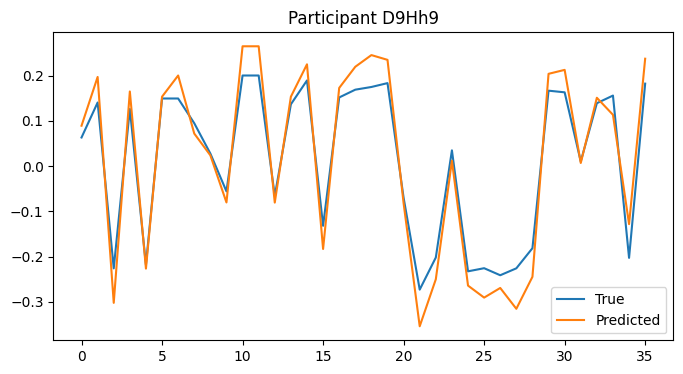

In [ ]:
import matplotlib.pyplot as plt

bad_pid = 'D9Hh9'
mask = np.array(all_test_participants) == bad_pid
plt.figure(figsize=(8, 4))
plt.plot(np.array(all_true_values)[mask], label='True')
plt.plot(np.array(all_fusion_preds)[mask], label='Predicted')
plt.title(f'Participant {bad_pid}')
plt.legend()
plt.show()


#### **Ridge regression**

---



In [ ]:
# Try Ridge
results_ridge, metrics_ridge = run_evaluation_pipeline(df, gt_full_set, Ridge, {'alpha': 1.0})


 Arousal Model Running with Fusion Model: Ridge

=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.1007
Global R²: 0.7930
Global corr: 0.8926, p = 0.0000e+00

Average Fusion Weights across Participants:
FER_weight      0.0101
Pupil_weight    0.0204
GSR_weight      0.1666
dtype: float64

=== Summary (Excluding Outliers) ===

Filtered out 1 out of 45 participants.
       NRMSE      R2    corr    p
mean  0.0955  0.9022  0.9803  0.0
std   0.0560  0.1506  0.0499  0.0

Excluded participants:
   participant     NRMSE        R2      corr
21        Bs73  0.545565 -1.343059 -0.957457


#### **Random Forest Regression**

---



In [ ]:
# Try Random Forest
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, RandomForestRegressor, {'n_estimators': 100, 'random_state': 42})


 Arousal Model Running with Fusion Model: RandomForestRegressor

=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.1031
Global R²: 0.7828
Global corr: 0.8889, p = 0.0000e+00

=== Summary (Excluding Outliers) ===

Filtered out 1 out of 45 participants.
       NRMSE      R2    corr       p
mean  0.0987  0.8870  0.9760  0.0000
std   0.0667  0.2299  0.0696  0.0001

Excluded participants:
   participant    NRMSE        R2     corr
21        Bs73  0.53894 -1.286499 -0.95097


#### **GradientBoostingRegressor**

---



In [ ]:
# Try Gradient Boosting Regressor
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, GradientBoostingRegressor,
 {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'random_state': 42})


 Arousal Model Running with Fusion Model: GradientBoostingRegressor

=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.1056
Global R²: 0.7721
Global corr: 0.8842, p = 0.0000e+00

=== Summary (Excluding Outliers) ===

Filtered out 1 out of 45 participants.
       NRMSE      R2    corr       p
mean  0.1056  0.8728  0.9717  0.0000
std   0.0694  0.2543  0.0738  0.0003

Excluded participants:
   participant     NRMSE        R2      corr
21        Bs73  0.539032 -1.287272 -0.939888


#### **SVR Support Vector Regression**

---



In [ ]:
# Try SVR
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set,SVR, {'kernel':'rbf', 'C':1.0, 'epsilon':0.1})


 Arousal Model Running with Fusion Model: SVR

=== Arousal Model Overall Global Metrics ===
Global NRMSE: 0.1103
Global R²: 0.7513
Global corr: 0.8720, p = 0.0000e+00

=== Summary (Excluding Outliers) ===

Filtered out 1 out of 45 participants.
       NRMSE      R2    corr    p
mean  0.1193  0.8609  0.9686  0.0
std   0.0562  0.1763  0.0522  0.0

Excluded participants:
   participant     NRMSE        R2      corr
21        Bs73  0.553176 -1.408882 -0.952562


# Valence

Defining the parameters along with the features to be used for each modality:

In [ ]:
val_modality_configs = {
    "FER": {
        "params": {
            # SVR
            "kernel": "rbf",
            "degree": 2,
            "gamma": 0.0005,
            "coef0": 1,
            "tol": 0.01,
            "C": 50,
            "epsilon": 0.5,

            # LGBM
            "num_leaves": 31,
            "max_depth": -1,
            "learning_rate": 0.05,
            "n_estimators": 100,
            "min_child_samples": 20,
            "subsample": 0.6,
            "colsample_bytree": 0.6,
        },
        "svr_features": [
            "FER_Kurtosis_Valence_whole","FER_Max_Arousal_interval","FER_Mean_Valence_whole",
            "FER_Mean_Valence_interval","FER_Max_Arousal_whole","FER_Std_Valence_interval",
            "FER_Mean_Arousal_interval","FER_Min_Arousal_interval",
        ],
        "lgbm_features": [
            "FER_Kurtosis_Valence_whole", "FER_Kurtosis_Arousal_interval", "FER_Max_Arousal_whole",
            "FER_Kurtosis_Arousal_whole","FER_Kurtosis_Valence_interval","FER_Min_Valence_interval",
            "FER_Max_Arousal_interval", "FER_Min_Valence_whole","FER_Std_Valence_whole",
            "FER_Min_Arousal_interval","FER_Mean_Arousal_whole","FER_Max_Valence_interval",
            "FER_Max_Valence_whole","FER_Min_Arousal_whole","FER_Mean_Arousal_interval",
            "FER_Mean_Valence_whole","FER_Std_Arousal_interval","FER_Std_Arousal_whole","FER_Std_Valence_interval",
        ],
    },
    "Pupil": {
        "params": {
            # SVR
            "kernel": "rbf",
            "degree": 2,
            "gamma": 1e-3,
            "coef0": 1,
            "tol": 1e-4,
            "C": 1,
            "epsilon": 0.5,

            # LGBM
            "num_leaves": 31,
            "max_depth": -1,
            "learning_rate": 0.1,
            "n_estimators": 100,
            "min_child_samples": 20,
            "subsample": 1.0,
            "colsample_bytree": 1.0,
        },
        "svr_features": [
            "corr_auc_whole","avg_auc_whole","corr_max_whole",
            "diff_skewness_whole","avg_max_whole","corr_mean_whole","avg_mean_whole",
            "avg_min_whole","corr_skewness_whole","avg_skewness_whole","corr_min_whole",
            "diff_min_whole","avg_kurtosis_whole","diff_max_whole","diff_mean_whole",
            "corr_std_whole","diff_std_whole","avg_std_whole",

            "corr_auc_interval","avg_auc_interval","corr_max_interval",
            "diff_skewness_interval","avg_max_interval","corr_mean_interval","avg_mean_interval",
            "avg_min_interval","corr_skewness_interval","avg_skewness_interval","corr_min_interval",
            "diff_min_interval","avg_kurtosis_interval","diff_max_interval","diff_mean_interval",
            "corr_std_interval","diff_std_interval","avg_std_interval",
        ],
        "lgbm_features": [
            'avg_max_whole', 'avg_min_whole', 'avg_mean_whole',
            'avg_std_whole', 'avg_kurtosis_whole', 'avg_skewness_whole', 'avg_auc_whole', 'corr_max_whole',
            'corr_min_whole', 'corr_mean_whole', 'corr_std_whole', 'corr_kurtosis_whole', 'corr_skewness_whole',
            'corr_auc_whole', 'diff_max_whole', 'diff_min_whole', 'diff_mean_whole', 'diff_std_whole',
            'diff_kurtosis_whole', 'diff_skewness_whole', 'diff_auc_whole',


                'avg_max_interval', 'avg_min_interval', 'avg_mean_interval',
            'avg_std_interval', 'avg_kurtosis_interval', 'avg_skewness_interval', 'avg_auc_interval', 'corr_max_interval',
            'corr_min_interval', 'corr_mean_interval', 'corr_std_interval', 'corr_kurtosis_interval', 'corr_skewness_interval',
            'corr_auc_interval', 'diff_max_interval', 'diff_min_interval', 'diff_mean_interval', 'diff_std_interval',
            'diff_kurtosis_interval', 'diff_skewness_interval', 'diff_auc_interval'
        ],
    },
    "GSR": {
        "params": {
            # SVR
            "kernel": "rbf",
            "degree": 2,
            "gamma": 5e-4,
            "coef0": 1,
            "tol": 1e-3,
            "C": 1,
            "epsilon": 5e-1,

            # LGBM
            "num_leaves": 31,
            "max_depth": -1,
            "learning_rate": 0.1,
            "n_estimators": 500,
            "min_child_samples": 40,
            "subsample": 0.6,
            "colsample_bytree": 0.6,
        },
        "svr_features": [
            "freqKurtEDA_whole", "freqKurtEDA_interval","kurtMFCC_2_interval",
            "hoc_0_interval", "skewEDA_interval","skewMFCC_5_interval",
            "skewMFCC_6_interval", "meanPeakAmplitude_interval","stdMFCC_2_interval",
            "stdEDA_interval","meanMFCC_3_interval","meanMFCC_11_interval",
            "rmsWavelet_1_interval","meanMFCC_5_interval","mobility_interval","sppw_whole","energyDistribution_0_interval",
        ],
        "lgbm_features": [
            "freqKurtEDA_whole", "freqKurtEDA_interval","freqSkewEDA_interval",
            "freqSkewEDA_whole","skewMFCC_11_interval","energyWavelet_4_interval",
            "rmsWavelet_4_interval","energyDistribution_0_whole","energyWavelet_0_interval",
            "stdMFCC_11_whole", "meanMFCC_12_whole","stdMFCC_12_whole",
            "energyWavelet_2_interval","energyDistribution_2_interval","spectralPowerBand(0.3-0.4)_interval",
            "minSpectralPower_whole","energyDistribution_6_whole","stdMFCC_4_interval",
            "meanMFCC_12_interval","kurtMFCC_2_interval","energyDistribution_8_interval",
            "energyWavelet_3_interval","spectralPowerBand(0.3-0.4)_whole","kurtMFCC_4_interval",
            "stdMFCC_0_interval","energyWavelet_1_interval","meanSecondDerivative_interval",
            "skewMFCC_12_interval","phasicPowers_0_interval","auc_interval",
            "energyDistribution_4_interval","activity_interval","spectralPowerBand(0.4-0.5)_interval",
            "medianMFCC_11_interval","rmsWavelet_3_interval","stdMFCC_12_interval",
            "medianMFCC_10_interval","skewEDA_interval","stdMFCC_10_whole","rmsWavelet_0_interval",
            "kurtMFCC_0_interval", "medianMFCC_12_interval", "stdMFCC_5_interval","energyDistribution_2_whole",
            "stdMFCC_10_interval","varSpectralPower_interval","hoc_2_whole",
            "energyDistribution_1_whole","kurtMFCC_12_whole","meanSecondDerivative_whole",
        ],
    },
}


In [ ]:
def get_train_test_data(df, gt_full_set, test_pid):
    """Split data into train and test and merge correctly with ground truth."""
    test_data = df[df["participant"] == test_pid].copy()
    test_gt = gt_full_set[gt_full_set["participant"] == test_pid]
    test_data = test_data.merge(
    test_gt[["participant", "video", "Valence"]],
      on=["participant", "video"],
          how="inner",
      )

    train_data = df[df["participant"] != test_pid].copy()

    pid_gt = load_ground_truth_exclude(test_pid)
    pid_gt.rename(
          columns={"Participant": "participant", "Stimulus_Name": "video"}, inplace=True
      )

    train_data = train_data.merge(
          pid_gt[["participant", "video", "Valence"]],
          on=["participant", "video"],
          how="inner",
      )

    return train_data, test_data


def train_modality_model(
    train_data, test_data, type_features, features, svr_features, lgbm_features, stacked_params
):
    """Train model on specific modality features."""
    X_train = train_data[features]
    y_train = train_data["Valence"]
    X_test = test_data[features]
    y_test = test_data["Valence"]

    train_df = pd.DataFrame(X_train, columns=features)
    train_df["Valence"] = y_train.values
    test_df = pd.DataFrame(X_test, columns=features)


    if type_features == "pupil":
      model = HistGradientBoostingRegressor(max_depth=5, learning_rate=0.01, max_iter=200)
      model.fit(X_train, y_train)
      preds_val = model.predict(X_test)
      preds_train = model.predict(X_train)
    else:
      model = StackedSvrLgbmModel(
          svr_features=svr_features, lgbm_features=lgbm_features, **stacked_params
      )

      preds_val = model.train_and_val(train_df, test_df, y_train)
      preds_train = model.test(train_df)

    return model, preds_train, preds_val, y_test.values


def evaluate_fusion_model(y_true, y_pred):
    """ Calculate evaluation metrics. """
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (y_true.max() - y_true.min())
    r2 = r2_score(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)
    return {"NRMSE": nrmse, "R2": r2, "corr": corr, "p": p_val}


def get_level1_train_data(
    train_data, fer_features, pupil_features, gsr_features, val_ratio=0.1
):
    """ Create validation set predictions for training the fusion model (level-1). """
    modality_train, modality_val = train_test_split(
        train_data, test_size=val_ratio, random_state=42
    )

    # Train each modality model on modality_train
    # FER model
    model_fer, _, val_fer, _ = train_modality_model(
        modality_train,
        modality_val,
        "fer",
        fer_features,
        svr_features=ar_modality_configs["FER"]["svr_features"],
        lgbm_features=ar_modality_configs["FER"]["lgbm_features"],
        stacked_params=ar_modality_configs["FER"]["params"],
    )

    # Pupil model
    model_pupil, _, val_pupil, _ = train_modality_model(
        modality_train,
        modality_val,
        "pupil",
        pupil_features,
        svr_features=ar_modality_configs["Pupil"]["svr_features"],
        lgbm_features=ar_modality_configs["Pupil"]["lgbm_features"],
        stacked_params=ar_modality_configs["Pupil"]["params"],
    )

    # GSR model
    model_gsr, _, val_gsr, y_val = train_modality_model(
        modality_train,
        modality_val,
        "gsr",
        gsr_features,
        svr_features=ar_modality_configs["GSR"]["svr_features"],
        lgbm_features=ar_modality_configs["GSR"]["lgbm_features"],
        stacked_params=ar_modality_configs["GSR"]["params"],
    )

    # Stack predictions to create fusion training input
    fusion_X_train = np.vstack([val_fer, val_pupil, val_gsr]).T
    fusion_y_train = y_val

    return fusion_X_train, fusion_y_train, model_fer, model_pupil, model_gsr


def run_participant_loop(df, gt_full_set, fusion_model_cls, fusion_model_kwargs={}):
    """ Get each participant in LOPO loop, train and predict with the model, evaluate, store the metrics."""
    participants = df["participant"].unique()
    participant_results = []
    fusion_weights = {}
    all_fusion_preds, all_true_values, all_test_participants = [], [], []

    for test_pid in participants:
        train_data, test_data = get_train_test_data(df, gt_full_set, test_pid)
        if train_data is None or test_data is None:
            continue  # Skip participant

        # Get level-1 training data without leakage
        (
            fusion_X_train,
            fusion_y_train,
            model_fer,
            model_pupil,
            model_gsr,
        ) = get_level1_train_data(
            train_data, fer_features, pupil_features, gsr_features
        )

        # Predict on test set using the trained modality models
        X_test_fer = test_data[fer_features]
        X_test_pupil = test_data[pupil_features]
        X_test_gsr = test_data[gsr_features]
        y_test = test_data["Valence"].values

        # Predict using trained models
        test_fer_preds = model_fer.test(pd.DataFrame(X_test_fer, columns=fer_features))
        test_pupil_preds = model_pupil.predict(pd.DataFrame(X_test_pupil, columns=pupil_features))
        test_gsr_preds = model_gsr.test(pd.DataFrame(X_test_gsr, columns=gsr_features))

        # Evaluate modalities individually
        fer_metrics = evaluate_fusion_model(y_test, test_fer_preds)
        pupil_metrics = evaluate_fusion_model(y_test, test_pupil_preds)
        gsr_metrics = evaluate_fusion_model(y_test, test_gsr_preds)

        # Rename keys to make clear it is per modality
        fer_metrics = {f"FER_{k}": v for k, v in fer_metrics.items()}
        pupil_metrics = {f"Pupil_{k}": v for k, v in pupil_metrics.items()}
        gsr_metrics = {f"GSR_{k}": v for k, v in gsr_metrics.items()}

        # Stack for fusion
        fusion_X_test = np.vstack([test_fer_preds, test_pupil_preds, test_gsr_preds]).T

        # Normalize fusion model input
        fusion_scaler = StandardScaler()
        fusion_X_train = fusion_scaler.fit_transform(fusion_X_train)
        fusion_X_test = fusion_scaler.transform(fusion_X_test)

        # Train and predict with fusion model
        model_fusion = fusion_model_cls(**fusion_model_kwargs)
        model_fusion.fit(fusion_X_train, fusion_y_train)
        fusion_preds = model_fusion.predict(fusion_X_test)

        # Store weights if they are available
        if hasattr(model_fusion, "coef_"):
            fusion_weights[test_pid] = model_fusion.coef_

        # Evaluate the fusion model
        fusion_metrics = evaluate_fusion_model(y_test, fusion_preds)
        fusion_metrics["participant"] = test_pid

        # Merge all metrics
        all_metrics = {
            "participant": test_pid,
            **fusion_metrics,
            **fer_metrics,
            **pupil_metrics,
            **gsr_metrics,
        }

        participant_results.append(all_metrics)

        # Store predictions
        all_fusion_preds.extend(fusion_preds)
        all_true_values.extend(y_test)
        all_test_participants.extend([test_pid] * len(y_test))

    return (
        participant_results,
        fusion_weights,
        all_fusion_preds,
        all_true_values,
        all_test_participants,
    )


In [ ]:
def evaluate_global_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    corr, p_val = pearsonr(y_true, y_pred)
    return {
        'RMSE': rmse,
        'NRMSE': nrmse,
        'R2': r2,
        'corr': corr,
        'p': p_val
    }


def print_global_metrics(metrics, title="=== Valence Model Overall Global Metrics ==="):
    print(f"\n{title}")
    print(f"Global NRMSE: {metrics['NRMSE']:.4f}")
    print(f"Global R²: {metrics['R2']:.4f}")
    print(f"Global corr: {metrics['corr']:.4f}, p = {metrics['p']:.4e}")


def print_fusion_weights_summary(fusion_weights):
    if fusion_weights:
        weights_df = pd.DataFrame(fusion_weights).T
        weights_df.columns = ['FER_weight', 'Pupil_weight', 'GSR_weight']
        print("\nAverage Fusion Weights across Participants:")
        print(weights_df.mean().round(4))


def print_per_participant_metrics(results_df):
    print("\n=== Valence Model Per-Participant Fusion Metrics ===")
    print(results_df.round(4))
    summary = results_df[['NRMSE', 'R2', 'corr', 'p']].agg(['mean', 'std'])
    print("\n=== Summary Across Participants ===")
    print(summary.round(4))


def print_filtered_summary(results_df):
    filtered = results_df[
        (results_df['R2'] > -1.0) &                 # Removes models with extremely poor fit
        (results_df['NRMSE'] < 1.5) &              # Removes predictions with very high error
        (results_df['corr'].abs() > 0.2)           # Keeps only modestly correlated results
    ]
    summary_filtered = filtered[['NRMSE', 'R2', 'corr', 'p']].agg(['mean', 'std'])
    print("\n=== Summary (Excluding Outliers) ===")
    print(f"\nFiltered out {len(results_df) - len(filtered)} out of {len(results_df)} participants.")
    print(summary_filtered.round(4))
    excluded = results_df[~results_df.index.isin(filtered.index)]
    print("\nExcluded participants:")
    print(excluded[['participant', 'NRMSE', 'R2', 'corr']])


def run_evaluation_pipeline(df, gt_full_set, model_cls, model_kwargs):
    print(f"\n VALENCE Running with Fusion Model: {model_cls.__name__}")
    participant_results, fusion_weights, all_preds, all_true, all_test_participants = run_participant_loop(
        df, gt_full_set, model_cls, model_kwargs
    )

    global_metrics = evaluate_global_metrics(all_true, all_preds)

    print_global_metrics(global_metrics)
    print_fusion_weights_summary(fusion_weights)

    results_df = pd.DataFrame(participant_results)
    print_per_participant_metrics(results_df)
    print_filtered_summary(results_df)

    return results_df, global_metrics

#### **Linear Regression**

---



In [ ]:
# ------ Run and Print Results -----
fusion_model_cls = LinearRegression
fusion_model_kwargs = {}

participant_results, fusion_weights, all_fusion_preds, all_true_values, all_test_participants = run_participant_loop(df, gt_full_set, fusion_model_cls, fusion_model_kwargs)

global_metrics = evaluate_global_metrics(all_true_values, all_fusion_preds)

print_global_metrics(global_metrics)
print_fusion_weights_summary(fusion_weights)


=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.0804
Global R²: 0.8800
Global corr: 0.9381, p = 0.0000e+00

Average Fusion Weights across Participants:
FER_weight      0.0119
Pupil_weight    0.0636
GSR_weight      0.2785
dtype: float64


In [ ]:
results_df = pd.DataFrame(participant_results)
print_per_participant_metrics(results_df)


=== Valence Model Per-Participant Fusion Metrics ===
   participant   NRMSE      R2    corr       p  FER_NRMSE  FER_R2  FER_corr  \
0        F5tXL  0.0557  0.9713  0.9881  0.0000     0.2715  0.3183    0.5677   
1         Gax8  0.0911  0.9233  0.9889  0.0000     0.3360 -0.0439    0.2200   
2        Hx7dO  0.0914  0.9228  0.9880  0.0000     0.2620  0.3653    0.6263   
3        wohkw  0.0437  0.9823  0.9926  0.0000     0.3624 -0.2143   -0.0492   
4        CVgs2  0.0863  0.9311  0.9930  0.0000     0.3250  0.0231    0.2395   
5        G4dLl  0.1179  0.8695  0.9943  0.0000     0.3170  0.0566    0.2409   
6        GFGzP  0.1190  0.8534  0.9309  0.0000     0.2967  0.0887    0.3364   
7        PPjCX  0.2377  0.4773  0.9572  0.0000     0.3143  0.0864    0.4549   
8        tMGNS  0.3268  0.0121  0.9947  0.0000     0.3345 -0.0346    0.1908   
9        5KB3V  0.0938  0.9187  0.9888  0.0000     0.2614  0.3682    0.6404   
10       LR96S  0.0940  0.9182  0.9946  0.0000     0.3091  0.1162    0.3604  

**Flag and Exclude Extreme Outliers for Summary Stats**



In [ ]:
print_filtered_summary(results_df)


=== Summary (Excluding Outliers) ===

Filtered out 0 out of 45 participants.
       NRMSE      R2    corr    p
mean  0.1130  0.8319  0.9749  0.0
std   0.0742  0.2317  0.0592  0.0

Excluded participants:
Empty DataFrame
Columns: [participant, NRMSE, R2, corr]
Index: []


**Investigate the Outliers**



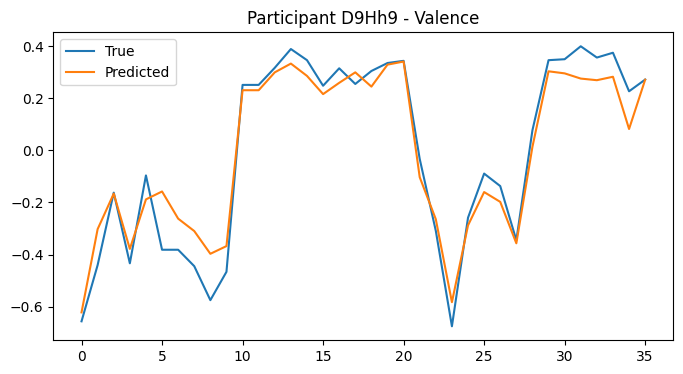

In [ ]:
import matplotlib.pyplot as plt

bad_pid = 'D9Hh9'
mask = np.array(all_test_participants) == bad_pid
plt.figure(figsize=(8, 4))
plt.plot(np.array(all_true_values)[mask], label='True')
plt.plot(np.array(all_fusion_preds)[mask], label='Predicted')
plt.title(f'Participant {bad_pid} - Valence')
plt.legend()
plt.show()


#### **Ridge regression**

---



In [ ]:
# Try Ridge
results_ridge, metrics_ridge = run_evaluation_pipeline(df, gt_full_set, Ridge, {'alpha': 1.0})


 VALENCE Running with Fusion Model: Ridge

=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.0805
Global R²: 0.8797
Global corr: 0.9379, p = 0.0000e+00

Average Fusion Weights across Participants:
FER_weight      0.0121
Pupil_weight    0.0671
GSR_weight      0.2738
dtype: float64

=== Valence Model Per-Participant Fusion Metrics ===
   participant   NRMSE      R2    corr       p  FER_NRMSE  FER_R2  FER_corr  \
0        F5tXL  0.0574  0.9696  0.9873  0.0000     0.2715  0.3183    0.5677   
1         Gax8  0.0902  0.9248  0.9882  0.0000     0.3360 -0.0439    0.2200   
2        Hx7dO  0.0931  0.9198  0.9874  0.0000     0.2620  0.3653    0.6263   
3        wohkw  0.0445  0.9817  0.9924  0.0000     0.3624 -0.2143   -0.0492   
4        CVgs2  0.0878  0.9287  0.9925  0.0000     0.3250  0.0231    0.2395   
5        G4dLl  0.1189  0.8672  0.9938  0.0000     0.3170  0.0566    0.2409   
6        GFGzP  0.1177  0.8565  0.9337  0.0000     0.2967  0.0887    0.3364   
7        PPjCX  0.235

#### **RandomForestRegressor**

---



In [ ]:
# Try Random Forest
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, RandomForestRegressor, {'n_estimators': 100, 'random_state': 42})


 VALENCE Running with Fusion Model: RandomForestRegressor

=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.0835
Global R²: 0.8706
Global corr: 0.9336, p = 0.0000e+00

=== Valence Model Per-Participant Fusion Metrics ===
   participant   NRMSE      R2    corr       p  FER_NRMSE  FER_R2  FER_corr  \
0        F5tXL  0.0485  0.9782  0.9895  0.0000     0.2715  0.3183    0.5677   
1         Gax8  0.0990  0.9094  0.9850  0.0000     0.3360 -0.0439    0.2200   
2        Hx7dO  0.0878  0.9287  0.9865  0.0000     0.2620  0.3653    0.6263   
3        wohkw  0.0695  0.9553  0.9778  0.0000     0.3624 -0.2143   -0.0492   
4        CVgs2  0.0878  0.9288  0.9894  0.0000     0.3250  0.0231    0.2395   
5        G4dLl  0.1066  0.8932  0.9895  0.0000     0.3170  0.0566    0.2409   
6        GFGzP  0.1206  0.8494  0.9273  0.0000     0.2967  0.0887    0.3364   
7        PPjCX  0.2728  0.3120  0.9202  0.0000     0.3143  0.0864    0.4549   
8        tMGNS  0.3528 -0.1511  0.9871  0.0000     0.33

#### **Gradient Boosting Regressor**

---



In [ ]:
# Try Gradient Boosting Regressor
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, GradientBoostingRegressor, {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth':3, 'random_state': 42})


 VALENCE Running with Fusion Model: GradientBoostingRegressor

=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.0857
Global R²: 0.8635
Global corr: 0.9302, p = 0.0000e+00

=== Valence Model Per-Participant Fusion Metrics ===
   participant   NRMSE      R2    corr    p  FER_NRMSE  FER_R2  FER_corr  \
0        F5tXL  0.0586  0.9683  0.9882  0.0     0.2715  0.3183    0.5677   
1         Gax8  0.0980  0.9111  0.9845  0.0     0.3360 -0.0439    0.2200   
2        Hx7dO  0.0846  0.9339  0.9878  0.0     0.2620  0.3653    0.6263   
3        wohkw  0.0805  0.9400  0.9700  0.0     0.3624 -0.2143   -0.0492   
4        CVgs2  0.0910  0.9234  0.9866  0.0     0.3250  0.0231    0.2395   
5        G4dLl  0.1183  0.8686  0.9860  0.0     0.3170  0.0566    0.2409   
6        GFGzP  0.1227  0.8441  0.9251  0.0     0.2967  0.0887    0.3364   
7        PPjCX  0.2771  0.2899  0.9170  0.0     0.3143  0.0864    0.4549   
8        tMGNS  0.3702 -0.2675  0.9809  0.0     0.3345 -0.0346    0.1908   
9 

#### **SVR Support Vector Regression**

---



In [ ]:
# Try SVR
results_rf, metrics_rf = run_evaluation_pipeline(df, gt_full_set, SVR, {'kernel':'rbf', 'C':1.0, 'epsilon':0.1})


 VALENCE Running with Fusion Model: SVR

=== Valence Model Overall Global Metrics ===
Global NRMSE: 0.0866
Global R²: 0.8608
Global corr: 0.9278, p = 0.0000e+00

=== Valence Model Per-Participant Fusion Metrics ===
   participant   NRMSE      R2    corr       p  FER_NRMSE  FER_R2  FER_corr  \
0        F5tXL  0.1039  0.9001  0.9510  0.0000     0.2715  0.3183    0.5677   
1         Gax8  0.1005  0.9066  0.9854  0.0000     0.3360 -0.0439    0.2200   
2        Hx7dO  0.1387  0.8221  0.9391  0.0000     0.2620  0.3653    0.6263   
3        wohkw  0.0660  0.9597  0.9826  0.0000     0.3624 -0.2143   -0.0492   
4        CVgs2  0.0907  0.9240  0.9847  0.0000     0.3250  0.0231    0.2395   
5        G4dLl  0.1173  0.8709  0.9889  0.0000     0.3170  0.0566    0.2409   
6        GFGzP  0.1244  0.8397  0.9240  0.0000     0.2967  0.0887    0.3364   
7        PPjCX  0.2416  0.4603  0.9455  0.0000     0.3143  0.0864    0.4549   
8        tMGNS  0.3270  0.0110  0.9902  0.0000     0.3345 -0.0346    0.19